## Задание 1. A/B–тестирование

1.1 Условие

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

1.2 Входные данные

В качестве входных данных вы имеете 4 csv-файла:
* groups.csv – файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (**А – контроль, B – целевая группа**) 
* groups_add.csv – дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
* active_studs.csv – файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
* checks.csv – файл с информацией об оплатах пользователей в дни проведения эксперимента. 

1.3 Вопросы

Предлагаем вам ответить на следующие вопросы:  

* На какие метрики вы смотрите в ходе анализа и почему?
* Имеются ли различия в показателях и с чем они могут быть связаны?
* Являются ли эти различия статистически значимыми?
* Стоит ли запускать новую механику на всех пользователей?
* Данный список вопросов не является обязательным, и вы можете при своём ответе опираться на собственный план.

1.4 Требования к ответу

*При выполнении тестового задания необходимо использовать язык программирования Python. 
В файле обязательно должны быть комментарии к тем действиям, которые вы выполняете с данными. 
Файл должен представлять собой законченный отчёт с выводами, сделанными в ходе исследования.*

In [2]:
!pip install requests

In [3]:
import numpy as np
import pandas as pd

In [8]:
import requests  # для запросов
from io import StringIO  # для чтения текста как файла

#скачивает csv по публичной ссылке яндекс диска и возвращает pd.dataframe
def download_csv_from_disk(public_url):
    api_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download'  # api для получения ссылки
    params = {'public_key': public_url}  # параметры запроса
    
    resp = requests.get(api_url, params=params)  # запрос к апи
    resp.raise_for_status()  # проверка ответа
    download_url = resp.json()['href']  # прямая ссылка на файл
    
    file_resp = requests.get(download_url)  # скачиваем файл
    file_resp.raise_for_status()  # проверка скачивания
    
    text = file_resp.text  # текст файла
    sep = ',' if text.count(',') >= text.count(';') else ';'  # определяем разделитель
    
    return pd.read_csv(StringIO(text), sep=sep)  # в dataframe

#загрузим все датасеты
groups = download_csv_from_disk('https://disk.yandex.ru/d/UhyYx41rTt3clQ')
groups_add = download_csv_from_disk('https://disk.yandex.ru/d/5Kxrz02m3IBUwQ')
active_studs = download_csv_from_disk('https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ')
checks = download_csv_from_disk('https://disk.yandex.ru/d/pH1q-VqcxXjsVA')

In [38]:
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [39]:
groups_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [40]:
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [41]:
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


Тк датасет group_add у нас добавочный, нужно проверить не продублируются ли данные два раза, если мы соединим group b group_add. Проверим, учтены ли данные в датасетах

In [45]:
groups_add['id'].isin(groups['id']).any()

False

In [46]:
groups_add['id'].isin(checks['student_id']).any()

True

In [47]:
 groups_add['id'].isin(active_studs['student_id']).any()

True

Видим, что из добавочное таблицы (groups_add) не учтены в groups, то соединим их.


In [48]:
group_full = pd.concat([groups_add, groups], ignore_index=True)
group_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74576 entries, 0 to 74575
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74576 non-null  int64 
 1   grp     74576 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


Проверим все ли данные из таблицы с оплатами учтены в активных пользователях


In [49]:
# создаем пустой список для неактивных пользователей
not_active_users = []

# проходим по всем student_id из таблицы с оплатами
for student_id in checks['student_id']:
    # если пользователя нет среди активных
    if student_id not in list(active_studs['student_id']):
        not_active_users.append(student_id)

active_checks = len(not_active_users)
print(active_checks, "пользователей совершили оплату, но их нет в таблице активных")


149 пользователей совершили оплату, но не считаются активными


Исключим пользователей, которые есть в таблице checks, но нет в таблице active_studs. Они не нужны для нашего анализа. Поэтому удалим из таблицы checks неактивных пользователей
, тк нам нужны только пользователи, которые зашли на платформу в дни проведения эксперимента.

In [53]:
checks = checks[checks['student_id'].isin(active_studs['student_id'])] #убираем неактивных
checks.count()

student_id    392
rev           392
dtype: int64

**Метрики!!**  
Изначально проведение A/B тестов планируется из-за сравнения новой механики и базовой(старой) оплаты услуг на сайте . Это означает, что пользователи не доходили до конечной цели (оплаты-приобретения продукта), возмонжо из-за сложной схемы оплаты.Значит отсюда можно понять, что основными метриками будут конверсии в платящего пользователя.
Основная метрика - CR. 
* CR - конверсия активного пользователя в платящего.
* ARPU - средний чек по пользователю.
* ARPPU - средний чек по платящему пользователю.

In [68]:
#переименуем столбцы, чтобы смерджить таблицы
active_studs = active_studs.rename(columns={'student_id':'id'})
checks = checks.rename(columns={'student_id':'id'})
#создадим один общий датафрейм, соединив все нужные таблицы в одну
full_df = active_studs.merge(checks, how='left', on='id').merge(group_full, how='left', on ='id')

In [69]:
full_df.head()

,id,rev,grp
0,581585,NaN,A
1,5723133,NaN,A
2,3276743,NaN,B
3,4238589,NaN,A
4,4475369,NaN,B


In [72]:
full_df.shape

(8341, 3)

In [71]:
full_df.id.nunique()

8341

Число уникальных id совпадает с общим числом id. Значит, выручка от всех покупок каждого конретного пользователя уже сведена в единое значение, и записи не нужно группировать по id студентов.  
Теперь нужно сгруппировать данные по тестовой и контрольной группам.

In [95]:
# группируем по А и B и считаем количество записей по столбцам id и rev
grouped = full_df.groupby('grp', as_index=False)[['id', 'rev']].count()
# добавляем колонку с конверсией: платящие / активные
grouped['active_cr'] = grouped['rev'] / grouped['id']
grouped = grouped.rename(columns={'id': 'n_active_students','rev':'n_paying_students'})
grouped

,grp,n_active_students,n_paying_students,active_cr
0,A,1538,78,0.050715
1,B,6803,314,0.046156


Отсюда мы видим, что конверсии не сильно различимы. Хотя конверсия в контрольной группе даже чуть больше чем в тестовой. Нужно удостовериться, что новая механика не дала результатов, и даже снизила показатель конверсии. Проведем статистический тест.

**Гипотезы:**  
* H0 - нет никакой взаимосвязи между cr и группами(различия статистически незначимы)
* H1 - различия статистически значимы(cr зависит от групп)  
Здесь применим критерий ХИ-квадрат, тк у нас две категориальные переменные, либо *купили* - 1, либо *не купили* - 0.  


In [96]:
full_df['status'] = np.where(full_df['rev'].fillna(0) > 0, '1', '0')

In [97]:
full_df.head()

,id,rev,grp,status
0,581585,NaN,A,0
1,5723133,NaN,A,0
2,3276743,NaN,B,0
3,4238589,NaN,A,0
4,4475369,NaN,B,0


In [103]:
#таблица сопряженности
crosstab = pd.crosstab(full_df.status, full_df.grp)
crosstab

grp,A,B
status,,
0,1460,6489
1,78,314


In [104]:
from scipy import stats

In [106]:
chi2_stat, p_value, dof, expected = stats.chi2_contingency(crosstab)
print(f"критерий хи-квадрат: {chi2_stat}, p-value: {p_value}")

критерий хи-квадрат: 0.48480826522557896, p-value: 0.48625240457231045


In [112]:
if p_value>0.05:
    print(f" Принимаем Н0. p-value - {p_value}.\n Различия статистически незначимы!")
else:
    print(f"Отклоняем Н0. p-value - {p_value} ")

 Принимаем Н0. p-value - 0.48625240457231045.
 Различия статистически незначимы!


Критерий Хи-квадрат показывет, что различия между значениями конверсии из активного пользователя в платящего в двух группах не являются стат значимыми. Это означает, что новая механика проведения оплаты не имеет как таковой пользы. Она не повышает нашу главную метрику.

In [116]:
full_df

,id,rev,grp,status
0,581585,NaN,A,0
1,5723133,NaN,A,0
2,3276743,NaN,B,0
3,4238589,NaN,A,0
4,4475369,NaN,B,0
...,...,...,...,...
8336,1794344,NaN,B,0
8337,296883,NaN,B,0
8338,3598448,NaN,B,0
8339,3610547,290.0,B,1


In [119]:
#считаем ARPU
arpu = full_df.groupby('grp', as_index=False).agg({'rev': 'sum','id': 'count'})
arpu['ARPU'] = (arpu['rev'] / arpu['id']).round(2)
arpu = arpu.rename(columns={'id': 'n_active_users', 'rev': 'total_revenue'})

# считаем ARPPU
arppu = full_df[full_df['rev'] > 0].groupby('grp', as_index=False).agg({'rev': 'sum','id': 'count'})
arppu['ARPPU'] = (arppu['rev'] / arppu['id']).round(2)
arppu = arppu.rename(columns={'id': 'n_paying_users', 'rev': 'total_revenue'})

print("ARPU:")
print(arpu[['grp', 'ARPU']])

print("ARPPU:")
print(arppu[['grp', 'ARPPU']])


ARPU:
  grp   ARPU
0   A  47.35
1   B  58.06
ARPPU:
  grp    ARPPU
0   A   933.59
1   B  1257.88


И ARPU и ARPPU с одного покупателя в тестовой группе по сравнению с контрольной выросли довольно значительно. 
Проверим равенство дисперсий для выбора стат теста.

C:\Users\aizha\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\aizha\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\aizha\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\aizha\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a len

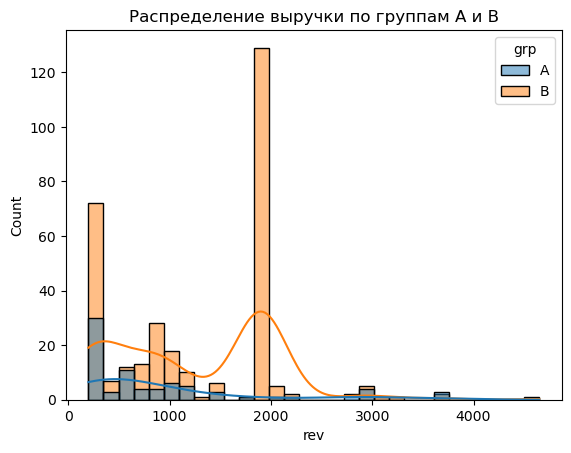

In [130]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(data=full_df, x="rev", hue="grp", kde=True, bins=30)
plt.title('Распределение выручки по группам A и B')
plt.show()


Из графика видно, что распределение выручки не является нормальным, поэтому для проверки равенства дисперский нужно воспользоваться тестом Левена.  
**Гипотезы:**  
* H0- Дисперсии выручки в двух группах равны (различия стат незначимы)
* H1 - Дисперсии выручки в двух группах различаются (различия стат значимы)

In [133]:
levene_stat, p_value = stats.levene(full_df.query('grp=="A"')['rev'].dropna(), full_df.query('grp=="B"')['rev'].dropna())

print(f"levene's test: stat={levene_stat}, p-value={levene_p}")


levene's test: stat=3.0756816999816055, p-value=0.08025675761347022


In [135]:
if p_value>0.05:
    print(f" Принимаем Н0. p-value - {p_value}.\n Дисперсии равны!")
else:
    print(f"Отклоняем Н0. p-value - {p_value} ")

 Принимаем Н0. p-value - 0.08025675761347022.
 Дисперсии равны!


Видим, что разброс значений(дисперсии) выручки в обеих группах статистически не отличается.Следовательно, мы можем использовать t-тест с предположением о равенстве дисперсий для сравнения средних значений между группами
  
**Гипотезы:**
* H0 - средние выручки равны в A b B(стат незначимы)
* H1 - средние выручки неравны A и B (стат значимы)

In [140]:
t_stat, p_value = stats.ttest_ind(full_df.query('grp == "A"')['rev'], full_df.query('grp == "B"')['rev'], nan_policy='omit')
print(f"t-test: stat={t_stat}, p-value={p_value}")

t-test: stat=-3.1337795050930985, p-value=0.0018562025265765867


In [141]:
if p_value>0.05:
    print(f" Принимаем Н0. p-value - {p_value}.\n Средние равны!")
else:
    print(f"Отклоняем Н0. p-value - {p_value} ")

Отклоняем Н0. p-value - 0.0018562025265765867 


**Вывод:**  
По результатам теста видим, что различия статистически значимы. Несмотря на то, что конверсия в оплату не изменилась, средняя выручка на платящего пользователя выросла значительно. Внесённые изменения, а именно новая механика оплаты, положительно повлияла на поведение пользователей, тк они приносят больше выручки. Значит, нужно выкатывать в прод изменения!

## Задание 2. SQL
### 2.1 Очень усердные ученики.

2.1.1 Условие

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.

**2.1.2 Задача**

Дана таблица peas:

|Название атрибута	|Тип атрибута|Смысловое значение
|:-----|:-----|:-----|
|st_id|	int|	ID ученика|
|timest|	timestamp|Время решения карточки|
|correct|	bool|Правильно ли решена горошина?|
|subject|	text|Дисциплина, в которой находится горошина|


Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов.  
NB! Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.

Сначала смотрим на месяцы в нашей таблице. С помощью запроса, видим, что у нас только один единственный месяц в таблице(текущий месяц - 10). 
``` SQL
select count(DISTINCT EXTRACT(MONTH from timest))
from peas
```
Напишем другой запрос, чтобы увидеть, какое количество дней в текущем месяце попали в нашу базу данных.
``` SQL
select count(distinct DATE(timest))
from peas
```
Он нам показал, что у нас всего 2 дня с данными. Следовательно, данных за текущий месяц у нас нет.


С помощью CTE получим список студентов за текущий месяц с правильно решенными заданиями, сгруппировав их по id. Затем посчитаем количество уникальных id (студентов), у которых количество правильно решенных задач равно или больше 20.
```SQL
WITH table1 as(
SELECT count(correct) as count_true, st_id
FROM peas
where correct is true
group by st_id 
)

SELECT count(distinct st_id) as n_successful_Students
From table1
where count_true >= 20 
```

В итоге получаем 136 очень усердных студентов
|n_successful_students|
|---|
|136|

### 2.2 Оптимизация воронки

2.2.1 Условие

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

**2.2.2 Задача**

Дана таблицы: **peas (см. выше), studs:**

|Название атрибута|	Тип атрибута|	Смысловое значение
|:-------|:--|:----
|st_id|	int|	 ID ученика|
|test_grp|	text|	 Метка ученика в данном эксперименте

и **final_project_check:**

|Название атрибута|	Тип атрибут|	Смысловое значение
|:----|:----|:----
|st_id|	int |	ID ученика
|sale_time|	timestamp|	Время покупки
|money|	int	|Цена, по которой приобрели данный курс
|subject|	text| 	Дисциплина

Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:
* ARPU 
* ARPAU 
* CR в покупку 
* СR активного пользователя в покупку 
* CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике  
**ARPU считается относительно всех пользователей, попавших в группы.**

Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.
Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.
Все данные хранятся в PostgreSQL
1. Для работы с таблицами перейдите в Redash https://redash.lab.karpov.courses

2. Выберите схему StartDA

3. Работайте с таблицами peas, studs и final_project_check, другие таблицы вам не нужны.

``` SQL
WITH 
--все пользователи и группы
users AS (
    SELECT st_id, test_grp
    FROM studs
),
--покупки
purchases AS (
    SELECT st_id, sum(money) as revenue
    FROM final_project_check
    group by st_id
),
--пользователи купившие курс по математике
math_buyers AS (
    SELECT  st_id
    FROM final_project_check
    WHERE subject = 'Math'
),
--пользователи,правильно решившие задачи
correct_peas AS (
    SELECT  st_id, subject
    FROM peas
    WHERE correct = TRUE
),

--активные пользователи(более 10 задач)
active_users AS (
    SELECT  st_id
    FROM correct_peas
    GROUP BY st_id
    HAVING COUNT(*) > 10
),

--активные по математике(2 и более задач по математике)
active_math_users AS (
    SELECT distinct st_id
    FROM correct_peas
    WHERE subject = 'Math'
    GROUP BY st_id
    having count(*) >= 2
),
final_table AS (
    SELECT 
        u.test_grp,
        u.st_id,
        COALESCE(p.revenue,0) AS revenue,
        CASE WHEN p.st_id IS NOT NULL THEN 1 ELSE 0 END AS is_buyer,
        CASE WHEN a.st_id IS NOT NULL THEN 1 ELSE 0 END AS is_active,
        CASE WHEN am.st_id IS NOT NULL THEN 1 ELSE 0 END AS is_active_math,
        CASE WHEN mb.st_id IS NOT NULL THEN 1 ELSE 0 END AS bought_math_course
    FROM users u
    LEFT JOIN purchases p ON p.st_id = u.st_id
    LEFT JOIN active_users a ON a.st_id = u.st_id
    LEFT JOIN active_math_users am ON am.st_id = u.st_id
    LEFT JOIN math_buyers mb ON mb.st_id = u.st_id
)

--итоговый расчет
SELECT 
    test_grp,
    sum(revenue) * 1.0 / count(st_id) as arpu,
    sum(revenue) * 1.0 / sum(is_active) as arpau,
    sum(is_buyer) * 1.0 / count(st_id) as cr,
    sum(is_buyer)* 1.0 / sum(is_active) as cr_active, 
    sum(bought_math_course) * 1.0 / sum(is_active_math) AS cr_active_math
FROM final_table
GROUP BY test_grp

```

  
  

**Вывод**

|test_grp|arpu |arpau |cr |cr_active |cr_active_math
|:----|:-----|:----|:----|:----|:-------|
|control| 4,540.98|	10,905.51|0.05|	0.12|	0.16	
|pilot| 11,508.47|35,364.58|	0.11|	0.33|	0.38


## Задание 3. Python
**3.1 Задача**

Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.
Реализуйте функцию, которая будет строить графики по получаемым метрикам.

Разобьем задание на подзадачи:
1. Первая функция:
* Принимет файл groups_add.csv(заголовки могут быть разные!!).
* Подгружает и объединяет с основными данными(groups).
* Пересчитываает метрики(CR,ARPU,ARPPU)

2. Вторая функция:
* Строит графики по рассчитанным метрикам(barplot или lineplot).



In [44]:
import requests
import pandas as pd
from io import StringIO
import seaborn as sns
import matplotlib.pyplot as plt

def auto_analysis(groups_url, groups_add_url, active_studs_url, checks_url):
    # функция для скачивания CSV
    def download_csv_from_disk(public_url):
        api_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download'
        params = {'public_key': public_url}
        resp = requests.get(api_url, params=params)
        resp.raise_for_status()
        download_url = resp.json()['href']
        file_resp = requests.get(download_url)
        file_resp.raise_for_status()
        text = file_resp.text
        sep = ',' if text.count(',') >= text.count(';') else ';'
        return pd.read_csv(StringIO(text), sep=sep)
    
    try:
        # загружаем данные
        groups = download_csv_from_disk(groups_url)
        groups_add = download_csv_from_disk(groups_add_url)
        active_studs = download_csv_from_disk(active_studs_url)
        checks = download_csv_from_disk(checks_url)

        # объединяем группы
        groups_full = pd.concat([groups, groups_add], ignore_index=True)

        # переименовываем столбцы у groups_add
        groups_full = groups_full.rename(columns={groups_add.columns[0]: 'student_id', groups_add.columns[1]: 'grp'})
        
        # оставляем только активных пользователей
        active_groups = groups_full.query('student_id in @active_studs.student_id')

        # объединяем с оплатами
        active_ab = active_groups.merge(checks, how='left', on='student_id')

        # создаём колонку, кто платил
        active_ab['paying'] = active_ab['rev'].fillna(0).apply(lambda x: 1 if x > 0 else 0)

        # добавляем проверку на пустые данные
        print("Проверка на количество строк после объединения: ", active_ab.shape)
        print(active_ab.head())  # для отладки

        # считаем метрики
        metrics = active_ab.groupby('grp').agg(
            n_active_users=('student_id', 'nunique'),
            n_paying_users=('paying', 'sum'),
            total_revenue=('rev', 'sum')
        ).reset_index()

        # конверсия и метрики
        metrics['CR'] = metrics['n_paying_users'] / metrics['n_active_users']  # конверсия
        metrics['ARPU'] = metrics['total_revenue'] / metrics['n_active_users']  # средний доход на юзера
        metrics['ARPPU'] = metrics['total_revenue'] / metrics['n_paying_users']  # средний доход на платящего

        print("\n Данные успешно загружены и метрики пересчитаны!")

        return metrics

    except Exception as e:
        print(f"Ошибка: {e}")
        return None



In [45]:
# Функция для построения графиков
def plot_metrics(metrics_df):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    sns.barplot(data=metrics_df, x='grp', y='CR', palette='Blues', ax=axes[0])
    axes[0].set_title('CR')
    axes[0].grid(axis='y')

    sns.barplot(data=metrics_df, x='grp', y='ARPU', palette='Greens', ax=axes[1])
    axes[1].set_title('ARPU')
    axes[1].grid(axis='y')

    sns.barplot(data=metrics_df, x='grp', y='ARPPU', palette='Oranges', ax=axes[2])
    axes[2].set_title('ARPPU')
    axes[2].grid(axis='y')

    plt.tight_layout()
    plt.show()


In [46]:
# загружаем и считаем метрики
metrics = auto_analysis(
    'https://disk.yandex.ru/d/UhyYx41rTt3clQ',  # groups
    'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ',  # groups_add
    'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ',  # active_studs
    'https://disk.yandex.ru/d/pH1q-VqcxXjsVA'   # checks
)

metrics

Проверка на количество строк после объединения:  (8341, 4)
   student_id grp    rev  paying
0        1627   A  990.0       1
1        2085   B    NaN       0
2        2215   B    NaN       0
3        3391   A    NaN       0
4        3401   B    NaN       0

 Данные успешно загружены и метрики пересчитаны!


,grp,n_active_users,n_paying_users,total_revenue,CR,ARPU,ARPPU
0,A,1538,78,72820.0000,0.050715,47.347204,933.589744
1,B,6803,314,394974.0035,0.046156,58.058798,1257.878992


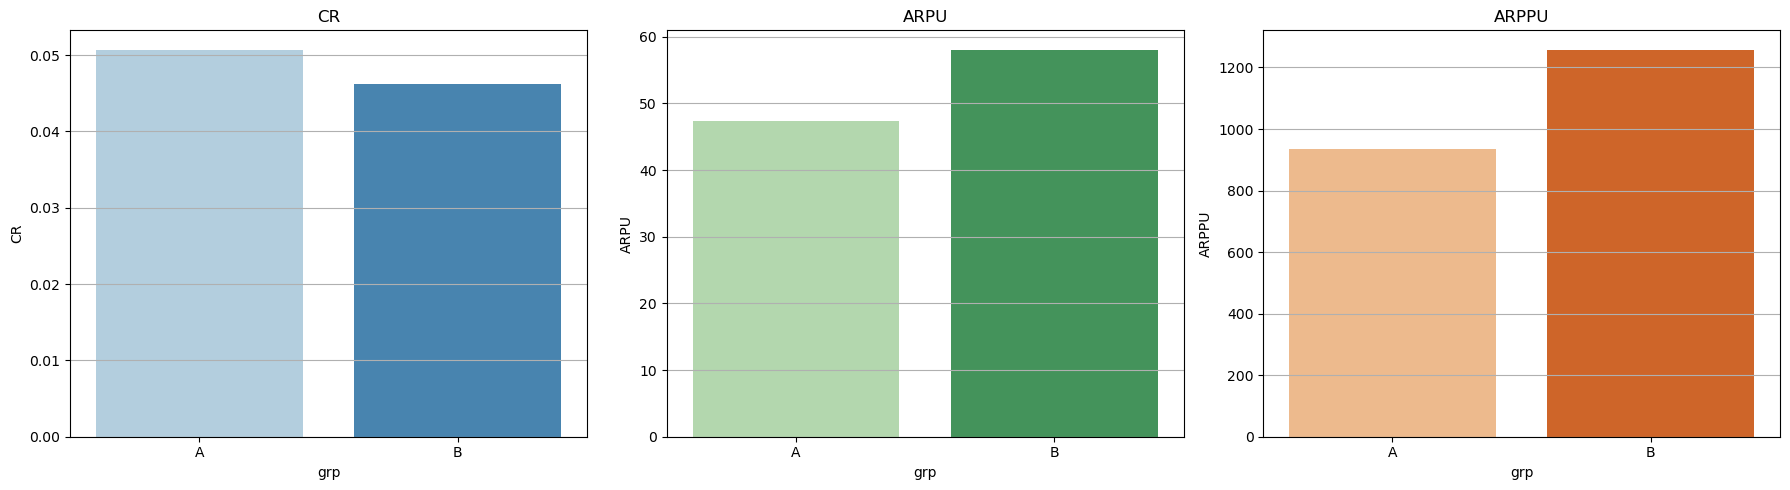

In [47]:
plot_metrics(metrics)